# Práctica 1

# Carga de Información 

Se cargará la información que será usada para esta practica.

In [248]:
##Importamos algunas librerias que nos servirán en el desarrollo del problema
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

Cargamos la información que nos ayudará con el modelo

In [249]:
estaturas_data = pd.read_csv("estaturas_Modelo.csv")

##Verificamos que haya cargado la información, y que tenga la forma requerida
print('Rango Tensor:',estaturas_data.ndim)
print('Forma Tensor:',estaturas_data.shape)
print('Vemos los primeros registros de la data:')
estaturas_data.head()

Rango Tensor: 2
Forma Tensor: (29, 2)
Vemos los primeros registros de la data:


,Estatura(metros),Edad(años)
0,1.77,26
1,1.74,31
2,1.72,24
3,1.78,34
4,1.65,32


Cargamos la información que nos ayudará en las pruebas (Test)

In [250]:
estaturas_test = pd.read_csv("valtest.csv")

##Verificamos que haya cargado la información, y que tenga la forma requerida
print('Rango Tensor:',estaturas_test.ndim)
print('Forma Tensor:',estaturas_test.shape)
print('Veamos los primeros registros de la data:')
estaturas_test.head()

Rango Tensor: 2
Forma Tensor: (8, 2)
Veamos los primeros registros de la data:


,Estatura(metros),Edad(años)
0,1.82,25
1,1.80,27
2,1.60,31
3,1.60,35
4,1.82,30


Cargamos los datos para la verificación de anomalias.

In [251]:
estaturas_anomalias = pd.read_csv("anomalias.csv")

##Verificamos que haya cargado la información, y que tenga la forma requerida
print('Rango Tensor:',estaturas_anomalias.ndim)
print('Forma Tensor:',estaturas_anomalias.shape)
print('Veamos los primeros registros de la data:')
estaturas_anomalias.head()

Rango Tensor: 2
Forma Tensor: (4, 2)
Veamos los primeros registros de la data:


,Estatura,Edad
0,0.25,2.4
1,175.10,2.5
2,0.15,250.0
3,150.00,14.0


# Parte 1 - Clustering

## Hard-Clustering con K-Means

Implementación manual de Metodo de Clasificación No Supervisada usando K-Means. Se implementará una función que en base a la información recibida y un número K determine la clasificación de la información.

1. Creamos una Clase que nos ayudará a entrenar el Modelo

In [252]:
from numpy import random

class K_Means:
    '''Implementación del Algoritmo K_Mean para Clasificación No supervisada'''
    
    def __init__(self, K=2, tol=0.001, max_iter=300):
        '''Constructor de la clase K_Means'''
        ##Inicializamos las varibles que usaremos para controlar el Modelo
        self.K = K
        self.tol = tol
        self.max_iter=max_iter
        
    def fit(self, data):
        '''Metodo para Entrenamiento del Modelo'''
        
        #Armamos los centroides - Números random entre los maximos y minimos de los datos proporcionados
        #Obtenemos Minimos y Maximos
        MinEstatura, MinEdad=np.min(data,axis=0)
        MaxEstatura, MaxEdad=np.max(data,axis=0)
        self.Centroides = np.hstack(((MaxEstatura - MinEstatura)*random.rand(self.K, 1)+MinEstatura,
                                (MaxEdad - MinEdad)*random.rand(self.K, 1)+MinEdad))
        
        #Iteramos para encontrar los centroides del modelo
        for i in range(self.max_iter):
            #Nos servirá para almacenar la clasificación(label) dada para cada valor de X
            clasificaciones = np.array([])
            
            #Para cada valor del vector X
            for _,x_val in enumerate(data):
                #Calculamos la distancia con los centroides
                distancia = [np.linalg.norm(x_val-self.Centroides[k]) for k in range(self.K)]
                #Determinamos el centroide mas cercando
                clasificacion = np.argmin(distancia)
                #Almacenamos la clasificación de acuerdo al centroide mas cercano
                clasificaciones=np.hstack((clasificaciones,clasificacion))
            
            #Almacenamos el valor anterior de los centroides
            old_Centroides =  np.array(self.Centroides)
            #calculamos el valor de los nuevos centroides
            for i in range(self.K):
                ##Solo se recalcula el centroide si tuvo datos que coincidieron con el mismo
                if (np.sum(data[clasificaciones==i])>0):
                    #Nueva ubicación del centroide en base al promedio
                    self.Centroides[i] = np.average(data[clasificaciones==i],axis=0)

            #Vemos si el valor aún no esa optimizado
            optimized= False if np.sum(np.sum(np.abs(self.Centroides- old_Centroides)/old_Centroides*100,axis=1)>self.tol)>0 else True

            #Si el valor ya esta optimizado - Arriba tolerancia - Nos salimos
            if optimized:
                break
    
    #Función de Costo
    def cost_Model(self,data,clasificaciones):
        '''Función que nos ayuda a calcular el costo del Modelo'''
        
        #Calculamos la distancia con los centroides - Elegimos por Dato
        costosxDato = [np.linalg.norm(data[i]-self.Centroides[int(clasificaciones[i])]) for i in range(len(data))]
        #Determinamos el centroide mas cercando
        Costo = np.average(costosxDato)
        
        #devolvemos el Costo
        return Costo
    
    def predict(self,data,calc_centroides):
        '''Función para Predicción en base al Modelo construido por FIT'''
        #Nos servirá para almacenar la clasificación(label) dada para cada valor de X
        clasificaciones = np.array([])
        
        #Para cada valor del vector X
        for _,x_pred in enumerate(data):
            #Calculamos la distancia con los centroides
            distancia = [np.linalg.norm(x_pred-calc_centroides[k]) for k in range(self.K)]
            #Determinamos el centroide mas cercando
            clasificacion = np.argmin(distancia)
            #Almacenamos la clasificación de acuerdo al centroide mas cercano
            clasificaciones=np.hstack((clasificaciones,clasificacion))
        
        return clasificaciones

2. Definimos la Función de Entrenamiento

In [253]:
def entrenamientoKMeans(X, K, epochs,show=True):
    
    #Definimos el costo despues del entrenamiento
    costoTrain = float('inf')
    #Modelo Minimo
    ModeloMin = K_Means(K)
    
    for _ in range(epochs):
        #Llamamos a la clase para el Modelo K_Means
        modelK = K_Means(K)

        #Entrenamos el Modelo
        modelK.fit(X)

        #Obtenemos los Labels del Modelo
        labels= modelK.predict(X,modelK.Centroides)
        
        #Costo del Modelo 
        costoM= modelK.cost_Model(X,labels)
        #Si el Costo del Entrenamiento es menor al modelo encontrado
        if costoTrain>costoM:
            costoTrain=costoM
            ModeloMin = modelK
            LabelsMin = labels
            centroides = modelK.Centroides
    if show==True:
        #Mostramos la grafica del Mejor Modelo
        plt.scatter(X[:,0],X[:,1], c=LabelsMin, cmap='viridis')
        plt.scatter(centroides[:, 0], centroides[:, 1], s=30,marker='x',c='r')
        plt.show()
        print("Costo Despues de la Función de Entrenamiento=",costoTrain)
    #Retornamos el modelo que nos 
    return ModeloMin,centroides,costoTrain

3. Creamos la Función para Predicción

In [254]:
def predicciónKMeans(KMeans_Model, Centroides,X,show=True):
    
    #Asignamos las etiquetas 
    labels = KMeans_Model.predict(X,Centroides)
    
    if show == True:
        #Mostramos en una grafica donde se ubican los datos de test
        plt.scatter(X[:,0],X[:,1], c=labels, cmap='viridis')
        plt.show()
    ##Retornamos la clasificación 
    return labels

3. Probamos la función de entrenamiento

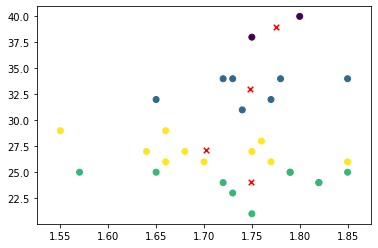

Costo Despues de la Función de Entrenamiento= 0.9842847092363377


In [255]:
X = estaturas_data.values
K = 4
epochs=100
model,centroides,costo = entrenamientoKMeans(X, K, epochs)

4. Probamos la función de Predicción

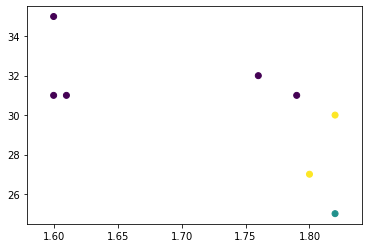

array([2., 3., 1., 1., 3., 1., 1., 1.])

In [256]:
X= estaturas_test.values
predicciónKMeans(model, centroides, X )

## Soft-clustering con GMM

Implementación del Metodo de clasificación con Soft-Clustering usando Scikit-Learn.

1. Creamos la función de entrenamiento.

In [257]:
from sklearn.mixture import GaussianMixture

def entrenamientoGMM(X, K,show=True):
    # Entrenamos el modelo con la data recibida
    gmm = GaussianMixture(n_components=K).fit(X)
    # Asignamos las etiquetas a la información recibida
    labels = gmm.predict(X)
    
    centroides = np.empty(shape=(gmm.n_components, X.shape[1]))
    for i in range(gmm.n_components):
        density = multivariate_normal(cov=gmm.covariances_[i], mean=gmm.means_[i]).logpdf(X)
        centroides[i, :] = X[np.argmax(density)]
    
    #Mostramos en una grafica como queda la distribución
    if show==True:
        plt.scatter(X[:,0],X[:,1], c=labels)
        plt.scatter(centroides[:, 0], centroides[:, 1], s=30,marker='x',c='r')
        #Mostramos la grafica
        plt.show()
    #Retornamos el modelo que nos 
    return gmm, centroides

2. Creamos la función para la predicción

In [258]:
def predicciónGMM(GMMModel, X):
    
    #Asignamos las etiquetas 
    labels = GMMModel.predict(X)
    #Retornamos la distribución de Probabilidad
    proba = GMMModel.predict_proba(X)
    #Mostramos en una grafica donde se ubican los datos de test
    plt.scatter(X[:,0],X[:,1], c=labels)
    plt.show()
    ##Retornamos la clasificación y la probabilidad
    return labels,proba

3. Pruebas

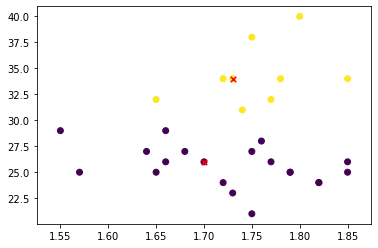

In [259]:
X = estaturas_data.values
model,centroides=entrenamientoGMM(X, 2)

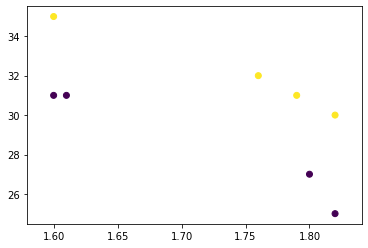

Cluster Asignado= [0 0 0 1 1 1 1 0]
Distribución de Probabilidad=
[[1.    0.   ]
 [0.989 0.011]
 [0.627 0.373]
 [0.002 0.998]
 [0.182 0.818]
 [0.002 0.998]
 [0.016 0.984]
 [0.513 0.487]]


In [260]:
X= estaturas_test.values
cluster, proba = predicciónGMM(model, X)
print('Cluster Asignado=',cluster)
print('Distribución de Probabilidad=')
print(proba.round(3))

## Experimentación y Selección del Mejor K

Ejecución de experimentos para la selección del Mejor "K".

1. Prueba con K = 2 - Usando K-Means



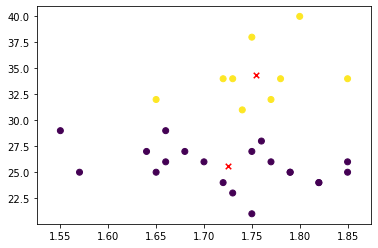

Costo Despues de la Función de Entrenamiento= 1.681819029148096
Ubicación Centroides:
[[ 1.7255     25.6       ]
 [ 1.75444444 34.33333333]]


In [261]:
X = estaturas_data.values
K = 2
epochs=100
model,centroides,costo = entrenamientoKMeans(X, K, epochs)
print('Ubicación Centroides:')
print(centroides)

2. Prueba con K = 2 - Usando GMM

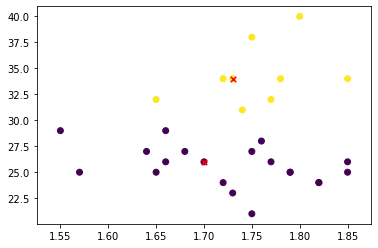

Ubicación Centroides:
[[ 1.7  26.  ]
 [ 1.73 34.  ]]


In [262]:
model,centroides=entrenamientoGMM(X, 2)
print('Ubicación Centroides:')
print(centroides)

#### Asignación Categoria - K=2 

Por la ubicación de los centroides, para K-2 se podría concluir que las categorias solamente se dividen los arriba de 30 años y los menores de 30 años. 

3. Prueba con K=3 - Usando K-Means

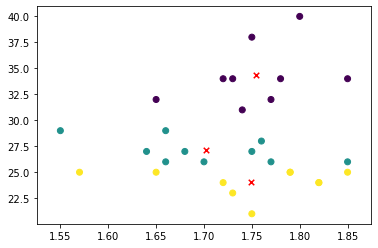

Costo Despues de la Función de Entrenamiento= 1.2834027052196983
Ubicación Centroides:
[[ 1.75444444 34.33333333]
 [ 1.702      27.1       ]
 [ 1.749      24.1       ]]


In [263]:
K = 3
epochs=100
model,centroides,costo = entrenamientoKMeans(X, K, epochs)
print('Ubicación Centroides:')
print(centroides)

4. Pruebas con K=3 - Usando GMM

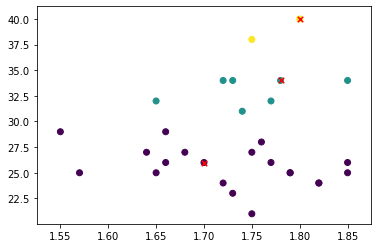

Ubicación Centroides:
[[ 1.7  26.  ]
 [ 1.78 34.  ]
 [ 1.8  40.  ]]


In [264]:
model,centroides=entrenamientoGMM(X, 3)
print('Ubicación Centroides:')
print(centroides)

#### Asignación Categoria - K=3

Por la ubicación de los centroides para K-3, muy parecido a K=2, la división de la categoria parace por la edad= Menores de 30, entre 30 y 37 años, y arriba de 37. 

5. Pruebas con K=4 - Usando K-Means

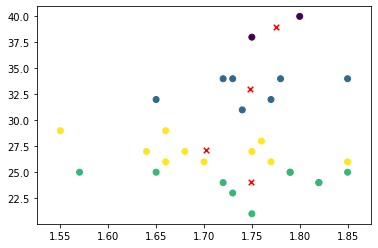

Costo Despues de la Función de Entrenamiento= 0.9842847092363377
Ubicación Centroides:
[[ 1.775      39.        ]
 [ 1.74857143 33.        ]
 [ 1.749      24.1       ]
 [ 1.702      27.1       ]]


In [265]:
K = 4
epochs=100
model,centroides,costo = entrenamientoKMeans(X, K, epochs)
print('Ubicación Centroides:')
print(centroides)

6. Prueba con K=4 - Usando GMM

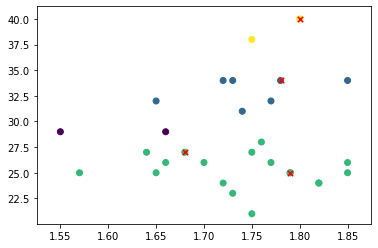

Ubicación Centroides:
[[ 1.68 27.  ]
 [ 1.78 34.  ]
 [ 1.79 25.  ]
 [ 1.8  40.  ]]


In [266]:
model,centroides=entrenamientoGMM(X, 4)
print('Ubicación Centroides:')
print(centroides)

#### Asignación Categoria - K=4

Por la ubicación de los centroides para K-4, muy parecido a K=3 y K=2, la división de la categoria parece por la edad= Menores de 27, entre 27 y 30 años, entre 30 y 37 años, y arriba de 37. 

7. Prueba con K=5 - Usando K-Means 

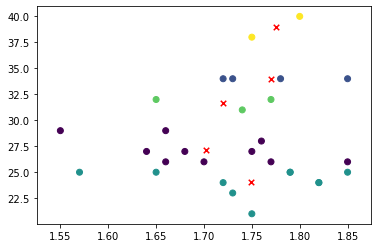

Costo Despues de la Función de Entrenamiento= 0.7606065635149044
Ubicación Centroides:
[[ 1.702      27.1       ]
 [ 1.77       34.        ]
 [ 1.749      24.1       ]
 [ 1.72       31.66666667]
 [ 1.775      39.        ]]


In [267]:
K = 5
epochs=100
model,centroides,costo = entrenamientoKMeans(X, K, epochs)
print('Ubicación Centroides:')
print(centroides)

8. Pruebas con K=5 - Usando GMM

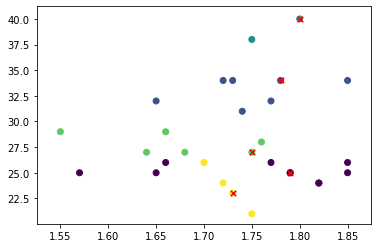

Ubicación Centroides:
[[ 1.79 25.  ]
 [ 1.78 34.  ]
 [ 1.8  40.  ]
 [ 1.75 27.  ]
 [ 1.73 23.  ]]


In [268]:
model,centroides=entrenamientoGMM(X, 5)
print('Ubicación Centroides:')
print(centroides)

#### Asignación Categoria - K=5

Por la ubicación de los centroides para K-4, muy parecido a K=3,K=2,K=4, la división de la categoria parece por la edad= Menores de 25,entre 25 y 27 años, entre 27 y 30 años, entre 30 y 37 años, y arriba de 37. 

9. Pruebas con K=6 - Usando K-Means

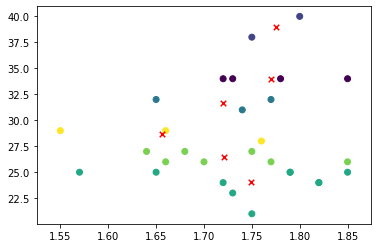

Costo Despues de la Función de Entrenamiento= 0.6009119758886738
Ubicación Centroides:
[[ 1.77       34.        ]
 [ 1.775      39.        ]
 [ 1.72       31.66666667]
 [ 1.749      24.1       ]
 [ 1.72142857 26.42857143]
 [ 1.65666667 28.66666667]]


In [269]:
K = 6
epochs=100
model,centroides,costo = entrenamientoKMeans(X, K, epochs)
print('Ubicación Centroides:')
print(centroides)

10. Pruebas con K=6 - Usando GMM

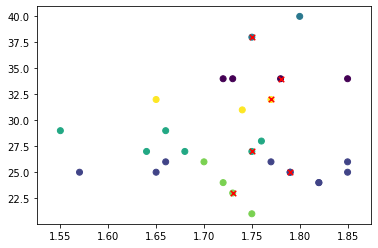

Ubicación Centroides:
[[ 1.78 34.  ]
 [ 1.79 25.  ]
 [ 1.75 38.  ]
 [ 1.75 27.  ]
 [ 1.73 23.  ]
 [ 1.77 32.  ]]


In [270]:
model,centroides=entrenamientoGMM(X, 6)
print('Ubicación Centroides:')
print(centroides)

#### Asignación Categoria - K=6

Por la ubicación de los centroides para K-4, muy parecido a K=3,K=2,K=4,K=5, la división de la categoria parece por la edad= Menores de 25,entre 25 y 27 años, entre 27 y 30 años, entre 30 y 33 años, entre 33 y 37 años, y arriba de 37. 

11. Pruebas con K=7 - Usando K-Means

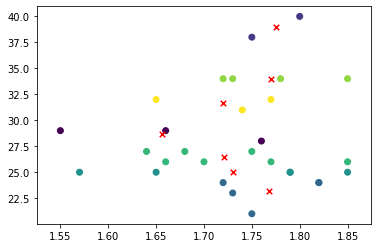

Costo Despues de la Función de Entrenamiento= 0.4701645984047299
Ubicación Centroides:
[[ 1.65666667 28.66666667]
 [ 1.775      39.        ]
 [ 1.768      23.2       ]
 [ 1.73       25.        ]
 [ 1.72142857 26.42857143]
 [ 1.77       34.        ]
 [ 1.72       31.66666667]]


In [271]:
K = 7
epochs=100
model,centroides,costo = entrenamientoKMeans(X, K, epochs)
print('Ubicación Centroides:')
print(centroides)

12. Pruebas con K=7 - Usando K-Means

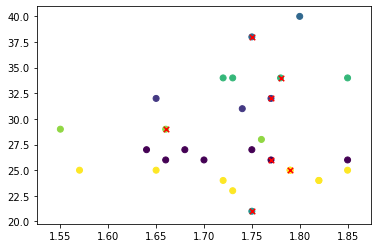

Ubicación Centroides:
[[ 1.77 26.  ]
 [ 1.77 32.  ]
 [ 1.75 38.  ]
 [ 1.75 21.  ]
 [ 1.78 34.  ]
 [ 1.66 29.  ]
 [ 1.79 25.  ]]


In [272]:
model,centroides=entrenamientoGMM(X, 7)
print('Ubicación Centroides:')
print(centroides)

#### Asignación Categoria - K=7

Por la ubicación de los centroides para K-4, muy parecido a K=3,K=2,K=4,K=5,K=6, la división de la categoria parece por la edad= Menores de 22 años, entre 22 y 25 años,entre 25 y 27 años, entre 27 y 30 años, entre 30 y 33 años, entre 33 y 37 años, y arriba de 37. 

### Conclusión

En base a la experimentación y como se distribuyen los datos en la gráfica, se ve que el K que mejor se ajusta es el **K=4**.

## Implementación del Metodo del Codo

Implementaremos el Metodo del Codo sobre con el Modelo de K-Means, y veremos si este algoritmo es adecuado para este problema.

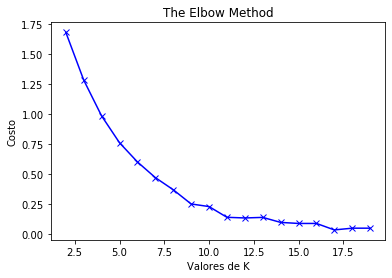

In [273]:
cost = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {}

#Usaremos la data de entrenamiento que ya tenemos
X = estaturas_data.values
#Numero de Iteraciones Máxima
epochs=100

# Probaremos con K desde 2 hasta 10
K = range(2,20) 

#Por cada K que se va a probar
for k in K: 
    #Building and fitting the model 
    model,centroides,costo = entrenamientoKMeans(X, k, epochs,False)
    cost.append(costo)
cost

plt.plot(K, cost, 'bx-')
plt.axis(xlim=(2, 19),option='equal')
plt.xlabel('Valores de K') 
plt.ylabel('Costo') 
plt.title('The Elbow Method') 
plt.show() 

### Resultados

La formación de _"Codo"_ se comienza a ver hasta un K=9 o 10, lo cual a mi apreciación, para un dataset tan pequeño que se tiene, parece muy ajustado. Veamos la distribución de los datos con un K=10.

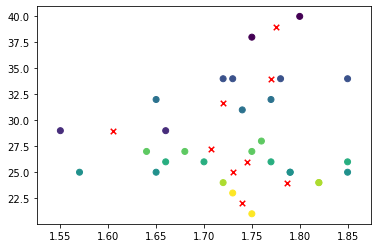

Costo Despues de la Función de Entrenamiento= 0.27670943231579137


array([5., 3., 7., 2., 3., 1., 6., 2., 5., 8., 8., 4., 7., 4., 4., 2., 5.,
       4., 5., 6., 3., 0., 4., 7., 0., 2., 1., 6., 6.])

In [274]:
K=9
model,centroides,costo = entrenamientoKMeans(X, K, epochs,True)
predicciónKMeans(model, centroides, X,False )

*De acuerdo a mi apreciación, el metodo de codo no es adecuado para este problema.*

## Estimación con Modelos

1. Cluster que k-means asigna cada uno.

Mostramos los cluster asignados a cada dato


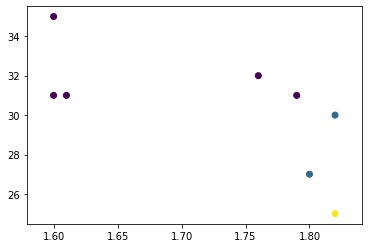

[3. 1. 0. 0. 1. 0. 0. 0.]


In [275]:
X_Pred= estaturas_test.values
X_Train = estaturas_data.values
K = 4
epochs=100
model,centroides,costo = entrenamientoKMeans(X_Train, K, epochs,False)
print('Mostramos los cluster asignados a cada dato')
print(predicciónKMeans(model, centroides, X_Pred ))

2. La probabilidad de pertenecer a cada cluster según GMM

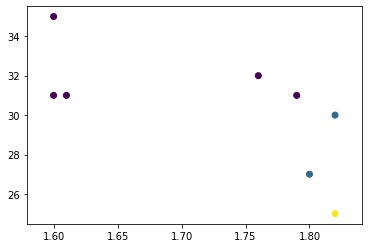

Cluster asignados= [3 1 0 0 1 0 0 0]
Probabilidad de Pertenecer a cada cluster= [[0.    0.174 0.    0.826]
 [0.    0.933 0.    0.067]
 [0.631 0.369 0.    0.   ]
 [0.999 0.001 0.    0.   ]
 [0.422 0.578 0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.986 0.014 0.    0.   ]
 [0.707 0.293 0.    0.   ]]


In [282]:
X_Pred= estaturas_test.values
X_Train = estaturas_data.values
K = 4
model,centroides=entrenamientoGMM(X_Train, K,False)
clusters,proba = predicciónGMM(model, X_Pred)
print('Cluster asignados=',clusters)
print('Probabilidad de Pertenecer a cada cluster=',proba.round(3))

# Parte 2 -  Detección de Anomalias

Entrenamiento del Modelo - Usando del Datos de la pestaña #1.

In [277]:
#Usaremos dos funciones que nos ayudaran a encontrar los datos de la distribución gaussiana
def estimateGaussian(dataset):
    '''Función que nos ayudará a determinar la media y la desviación estandar 
       de la distribución de nuestros datos'''
    mu = np.mean(dataset, axis= 0)
    sigma = np.cov(dataset.T)
    return mu,sigma

def multivariateGaussian(dataset, mu, sigma):
    '''Función que nos devolverá la función de probabilidad para nuestra dataset'''
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

Usando las funciones anteriores,determinamos los datos de la distribución para la data de entrenamiento.

In [278]:
X_Train = estaturas_data.values
mu,sigma= estimateGaussian(X_Train)
print('Distribución de Probabilidad de los datos de Entrenamiento')
print(multivariateGaussian(X_Train, mu, sigma))

Distribución de Probabilidad de los datos de Entrenamiento
[0.34191419 0.36947513 0.2834394  0.18450539 0.16646052 0.2703258
 0.20619402 0.07915274 0.12186773 0.12268719 0.22911876 0.25347203
 0.14473511 0.19952848 0.25347203 0.20061665 0.35546521 0.04090768
 0.25306917 0.40914669 0.29537546 0.01561441 0.10464836 0.14473511
 0.05122697 0.20614432 0.02555203 0.41157343 0.33306881]


Unificamos los datos de Test y Anomalias para la evaluación del mejor epsilon.

In [279]:
X_Test = np.vstack((estaturas_test.values,estaturas_anomalias.values))
print('Distribución de Probabilidad de los datos de Test')
print(multivariateGaussian(X_Test, mu, sigma).round(6))

Distribución de Probabilidad de los datos de Test
[0.175383 0.289287 0.077487 0.029393 0.230375 0.308262 0.295419 0.096412
 0.       0.       0.       0.      ]


### Selección Epsilon

En este caso en particular, todas las anomalias tienen una probabilidad de cero; por lo que elegir un epsilon especifico para este data set en particular esta dificil.

Podriamos elegir un $\varepsilon = 0.01$, que funcionaria muy bien; ya que el menor dato en nuestra data de entrenamiento es una probabilidad de 0.01561, y en la data de test el menor es de 0.0774.